# Can we learn controllers with BRAD?

Yes.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation, PillowWriter

In [2]:
# Pendcart dynamical system we will control
def pendcart(t, x, m, M, L, g, d, u):
    Sx = np.sin(x[2])
    Cx = np.cos(x[2])
    D = m * L * L * (M + m * (1 - Cx ** 2))
    
    dx = np.zeros(4)
    dx[0] = x[1]
    dx[1] = (1 / D) * (-m ** 2 * L ** 2 * g * Cx * Sx + m * L ** 2 * (m * L * x[3] ** 2 * Sx - d * x[1])) + m * L * L * (1 / D) * u
    dx[2] = x[3]
    dx[3] = (1 / D) * ((m + M) * m * g * L * Sx - m * L * Cx * (m * L * x[3] ** 2 * Sx - d * x[1])) - m * L * Cx * (1 / D) * u
    
    return dx

# Define thresholds for stopping criteria
def event_function(t, y):
    max_threshold = 20  # Maximum allowed value for the states
    min_threshold = -20 # Minimum allowed value for the states
    
    # Check if any state variable exceeds the thresholds
    if np.any(np.abs(y) > max_threshold):
        return 1  # Event is triggered
    if np.any(np.abs(y) < min_threshold):
        return -1  # Event is triggered
    
    return 0  # Event not triggered

# Visualize the cart and pendulum
def visualize_cart_pendulum(x, theta, L, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    cart_width = 1
    cart_height = 0.2
    wheel_radius = 0.05
    pendulum_x = x + L * np.sin(theta)
    pendulum_y = L * np.cos(theta)

    ax.clear()
    ax.plot([-2, 2], [-2 * wheel_radius, -2 * wheel_radius], 'k')  # Track
    ax.add_patch(plt.Rectangle((x - cart_width / 2, 0), cart_width, cart_height, fc='blue', ec='black'))
    ax.add_patch(plt.Circle((x - cart_width / 4, -wheel_radius), wheel_radius, fc='black'))
    ax.add_patch(plt.Circle((x + cart_width / 4, -wheel_radius), wheel_radius, fc='black'))
    ax.plot([x, pendulum_x], [cart_height, pendulum_y + cart_height], 'r', lw=2)
    ax.add_patch(plt.Circle((pendulum_x, pendulum_y + cart_height), 0.05, fc='red'))

    ax.set_xlim(-2, 2)
    ax.set_ylim(-1, 1.5)
    ax.set_aspect('equal')
    ax.set_xlabel('Position')
    ax.set_ylabel('Height')
    ax.set_title('Cart and Pendulum')
    ax.grid(zorder=-1)

## Cart-Pendulum without Control

In [5]:
# Parameters
m = 0.1  # mass of the pendulum
M = 1.0  # mass of the cart
L = 1.0  # length of the pendulum
g = 9.81  # acceleration due to gravity
d = 0.1  # damping coefficient
u = 0.0  # control input

# Initial conditions: [x, x_dot, theta, theta_dot]
x0 = [0.0, 0.0, np.pi / 4, 0.0]

# Time span
t_span = (0, 10)  # 0 to 10 seconds
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # points at which to store the computed solutions

# Integrate the system
sol = solve_ivp(pendcart, t_span, x0, args=(m, M, L, g, d, u), t_eval=t_eval)

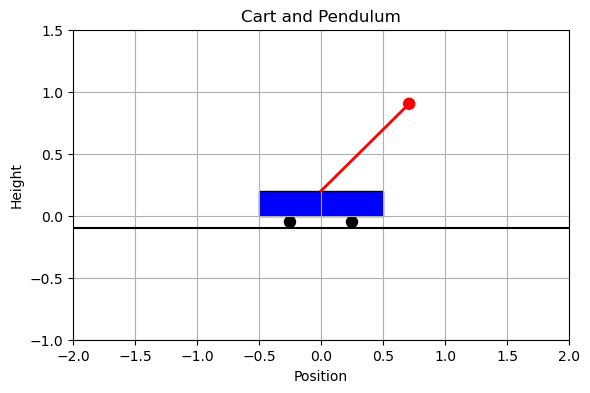

In [6]:
# Choose a specific instant in time (e.g., at the last time point)
index = 4
x = sol.y[0, index]
theta = sol.y[2, index]

# Visualize the cart and pendulum at that instant
visualize_cart_pendulum(x, theta, L)


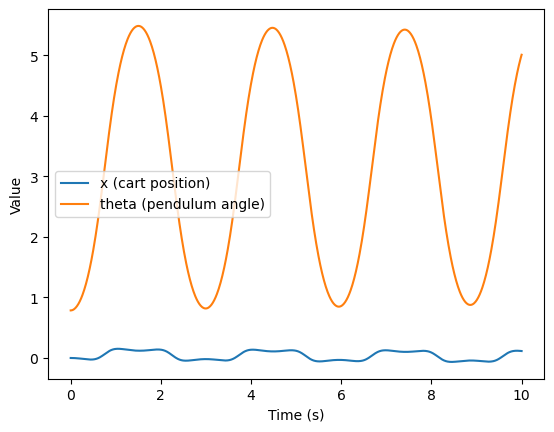

In [7]:
# Plot the results
plt.figure()
plt.plot(sol.t, sol.y[0], label='x (cart position)')
plt.plot(sol.t, sol.y[2], label='theta (pendulum angle)')
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.legend()
plt.show()

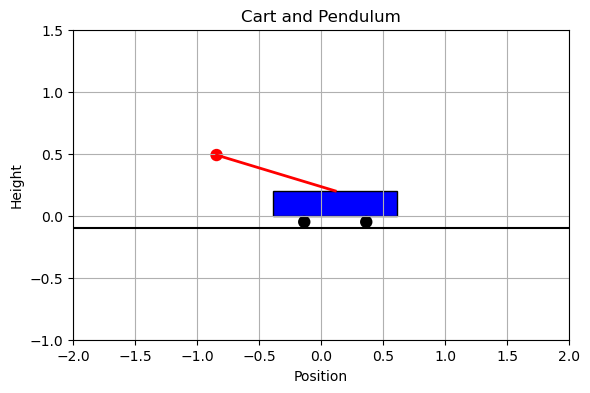

In [25]:
# Animation function
def animate(i):
    x = sol.y[0, i]
    theta = sol.y[2, i]
    visualize_cart_pendulum(x, theta, L, ax=ax)

# Set up the figure, the axis, and the plot element
fig, ax = plt.subplots()

# Create the animation
ani = FuncAnimation(fig, animate, frames=len(t_eval), interval=20)

# Save the animation as a GIF
ani.save('cart_pendulum_no_control.gif', writer=PillowWriter(fps=30))

plt.show()


## Cart-Pendulum with Optimal Control

### Least Quadratic Regulator

In [3]:
from scipy.linalg import solve_continuous_are

In [4]:
# Here the control term comes as u = -K @ x
def pendcart_LQR(t, x, m, M, L, g, d, K):
    Sx = np.sin(x[2])
    Cx = np.cos(x[2])
    D = m * L * L * (M + m * (1 - Cx ** 2))
    
    # Control input u using state feedback
    u = -K @ x
    
    dx = np.zeros(4)
    dx[0] = x[1]
    dx[1] = (1 / D) * (-m ** 2 * L ** 2 * g * Cx * Sx + m * L ** 2 * (m * L * x[3] ** 2 * Sx - d * x[1])) + m * L * L * (1 / D) * u
    dx[2] = x[3]
    dx[3] = (1 / D) * ((m + M) * m * g * L * Sx - m * L * Cx * (m * L * x[3] ** 2 * Sx - d * x[1])) - m * L * Cx * (1 / D) * u
    
    return dx

In [31]:
# Parameters
m = 0.1  # mass of the pendulum
M = 1.0  # mass of the cart
L = 1.0  # length of the pendulum
g = 9.81  # acceleration due to gravity
d = 0.1  # damping coefficient

# Linearized system matrices around the upright position (theta = 0)
A = np.array([[0, 1, 0, 0],
              [0, -d/M, -(m*g)/M, 0],
              [0, 0, 0, 1],
              [0, d/(M*L), (M+m)*g/(M*L), 0]])

B = np.array([[0],
              [1/M],
              [0],
              [-1/(M*L)]])

# LQR controller design
Q = np.diag([10, 1, 10, 1])  # State cost matrix
R = np.array([[0.1]])         # Control effort cost matrix

# Solve the Continuous Algebraic Riccati Equation (CARE)
P = solve_continuous_are(A, B, Q, R)

# Compute the LQR gain
K = np.linalg.inv(R) @ B.T @ P
print(K)

[[-10.         -12.24279807 -78.20411582 -24.64952553]]


In [18]:
K = np.array([[0.60, 1.50, 0.50, -0.50]])

In [27]:
# Initial conditions: [x, x_dot, theta, theta_dot]
x0 = [0.0, 0.0, - np.pi / 4, 0.0]

# Time span
t_span = (0, 25)  # 0 to 10 seconds
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # points at which to store the computed solutions

# Integrate the system with LQR control
sol = solve_ivp(pendcart_LQR, t_span, x0, args=(m, M, L, g, d, K), t_eval=t_eval)



/tmp/ipykernel_1496742/4292113657.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dx[1] = (1 / D) * (-m ** 2 * L ** 2 * g * Cx * Sx + m * L ** 2 * (m * L * x[3] ** 2 * Sx - d * x[1])) + m * L * L * (1 / D) * u
/tmp/ipykernel_1496742/4292113657.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dx[3] = (1 / D) * ((m + M) * m * g * L * Sx - m * L * Cx * (m * L * x[3] ** 2 * Sx - d * x[1])) - m * L * Cx * (1 / D) * u


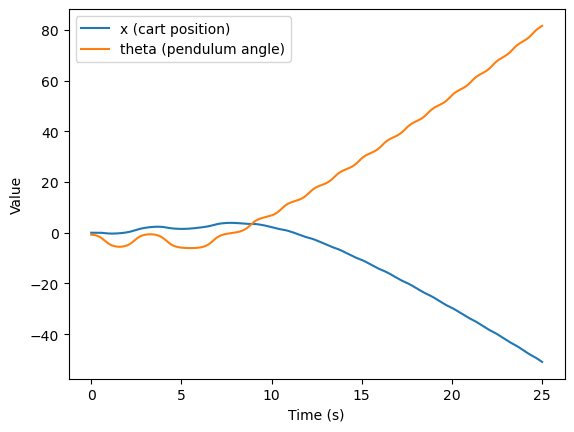

In [28]:
# Plot the results
plt.figure()
plt.plot(sol.t, sol.y[0], label='x (cart position)')
plt.plot(sol.t, sol.y[2], label='theta (pendulum angle)')
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.legend()
plt.show()

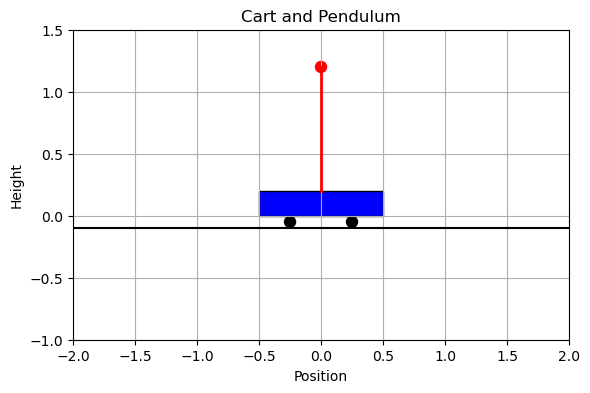

In [20]:
# Animation function
def animate(i):
    x = sol.y[0, i]
    theta = sol.y[2, i]
    visualize_cart_pendulum(x, theta, L, ax=ax)

# Set up the figure, the axis, and the plot element
fig, ax = plt.subplots()

# Create the animation
ani = FuncAnimation(fig, animate, frames=len(t_eval), interval=20)

# Save the animation as a GIF
ani.save('cart_pendulum_LQR_2.gif', writer=PillowWriter(fps=30))

plt.show()

## BRAD Optimized Controller

BRAD must select the feedback gain matrix `K` rather than selecting this matrix through the ARE

In [32]:
from BRAD import brad

In [33]:
bot = brad.chatbot()


Would you like to use a database with BRAD [Y/N]?


 N


2024-07-30 00:35:46 INFO semantic_router.utils.logger local


Welcome to RAG! The chat log from this conversation will be saved to /home/jpic/BRAD/2024-07-30_00-35-44/log.json. How can I help?


In [108]:
# Define the function to evaluate performance metrics
def evaluate_performance(sol):
    # Performance metrics: final position, final angle, and total control effort
    final_position = sol.y[0, -1]
    final_angle = sol.y[2, -1]
    total_control_effort = np.sum(np.abs(sol.y[1, :]))  # Example metric: sum of absolute values of x_dot
    
    return final_position, final_angle, total_control_effort

In [7]:
def evaluate_performance(sol):
    # Calculate the number of full rotations (crossings through horizontal position)
    crossings = np.sum(np.diff(np.sign(sol.y[2])) != 0)
    
    # Calculate the final position of the cart
    final_position = sol.y[0, -1]
    
    return crossings, final_position


In [9]:
# Parameters
m = 0.1  # mass of the pendulum
M = 1.0  # mass of the cart
L = 1.0  # length of the pendulum
g = 9.81  # acceleration due to gravity
d = 0.1  # damping coefficient

In [34]:
# Code to have BRAD set controller parameters
response = bot.invoke("""You are BRAD, a chatbot in charge of learning a controller. You are controlling a cart and pendulum with a LQR controller and you must select the feedback gain matrix. Your objective is to stabilize the pendulum by controlling the position of the cart. The gain matrix has elements: [x, dx/dt, theta, dtheta/dt].

Please propose several different gain matrices you would like tested. We will control the system based upon these and report the findings of each.

Optimal entries of K are between 0 and -100.

Please format your output as follows. You may propose as many values of K as you would like. Do not provide ANY additional text
**Output**
x=<x gain 1, x gain 2, x gain 3, ...>
dx/dt=<gain 1, ...>
theta=<gain 1, ...>
dtheta/dt=<gain 1, ...>""")

# Code to parse BRAD's response
response = response.split('Output**')
if len(response) - 1 == 2:
    response = response[len(response) - 1]
    response = response[1:]
else:
    response = response[len(response) - 1]
response = response.strip()
print(response)

for i in range(4):
    row = response.split('\n')[i].split('=')[1][1:-1]
    print(f'row={row}')
    if i == 0:
        K = np.zeros((4,row.count(',')))
    for j in range(K.shape[1]):
        K[i,j] = float(row.split(',')[j])

results = []
# Code to try controlling with BRAD's parameters
for itr in range(K.shape[1]):
    k = K[:,itr]
    k.reshape(-1)
    print(k.shape)

    # Initial conditions: [x, x_dot, theta, theta_dot]
    x0 = [0.0, 0.0, np.pi / 4, 0.0]
    
    # Time span
    t_span = (0, 1)  # 0 to 10 seconds
    t_eval = np.linspace(t_span[0], t_span[1], 100)  # points at which to store the computed solutions
    
    # Integrate the system with LQR control
    sol = solve_ivp(
        lambda t, y: pendcart_LQR(t, y, m, M, L, g, d, k),
        t_span,
        x0,
        t_eval=t_eval,
        events=event_function,
        vectorized=True
    )

    # Evaluate performance
    crossings, final_position = evaluate_performance(sol)
    
    # We need code to evaluate sol and use it to tell BRAD how that particular k matrix worked
    results.append({
            'k': k,
            'crossings': crossings,
            'final_position': final_position
        })


2024-07-30 00:36:51,662 - INFO - RAG


BRAD >> 0: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are BRAD, a chatbot in charge of learning a controller. You are controlling a cart and pendulum with a LQR controller and you must select the feedback gain matrix. Your objective is to stabilize the pendulum by controlling the position of the cart. The gain matrix has elements: [x, dx/dt, theta, dtheta/dt].

Please

2024-07-30 00:36:54,087 - INFO - 


route



2024-07-30 00:36:54,087 - INFO - RAG
2024-07-30 00:36:54,087 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are BRAD, a chatbot in charge of learning a controller. You are controlling a


> Finished chain.
**Output**
x=<-10, -20, -50, -80>
dx/dt=<-5, -10, -20, -30>
theta=<-15, -30, -60, -90>
dtheta/dt=<-2, -5, -10, -15>
x=<-10, -20, -50, -80>
dx/dt=<-5, -10, -20, -30>
theta=<-15, -30, -60, -90>
dtheta/dt=<-2, -5, -10, -15>
row=-10, -20, -50, -80
row=-5, -10, -20, -30
row=-15, -30, -60, -90
row=-2, -5, -10, -15
(4,)
(4,)
(4,)


/tmp/ipykernel_1496742/4292113657.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dx[0] = x[1]
/tmp/ipykernel_1496742/4292113657.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dx[1] = (1 / D) * (-m ** 2 * L ** 2 * g * Cx * Sx + m * L ** 2 * (m * L * x[3] ** 2 * Sx - d * x[1])) + m * L * L * (1 / D) * u
/tmp/ipykernel_1496742/4292113657.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dx[2] = x[3]
/tmp/ipykernel_1496742/4292113657.py:14: DeprecationWa

In [35]:
# Code to send feedback to BRAD
feedback = "**Feedback**\n"
for result in results:
    k_str = ', '.join(f'{val:.2f}' for val in result['k'])
    feedback += f"K={k_str}\n"
    feedback += f"Final Position={result['final_position']:.2f}\n"
    feedback += f"Crossings={result['crossings']:.2f}\n"
feedback = feedback.strip()
print(feedback)

**Feedback**
K=-10.00, -5.00, -15.00, -2.00
Final Position=43.82
Crossings=1.00
K=-20.00, -10.00, -30.00, -5.00
Final Position=2121.25
Crossings=1.00
K=-50.00, -20.00, -60.00, -10.00
Final Position=15961474.77
Crossings=1.00


In [36]:
# Code to have BRAD set controller parameters
template = """You are BRAD, a chatbot in charge of learning a controller. You are controlling a cart and pendulum with a LQR controller and you must select the feedback gain matrix.
Your objective is to stabilize the pendulum upright by controlling the position of the cart, and to keep the cart's horizontal position as close to 0 as possible.
The gain matrix has elements: [x, dx/dt, theta, dtheta/dt].

From the previous round, the following gain matrices (K) were tested:
{feedback}

Please propose several different gain matrices you would like tested. Your new proposals should be based on or similar to the proposals deemed most successful last time.

We will control the system based upon these and report the findings of each.

Please format your output as follows. Do not provide ANY additional text
**Output**
x=<x gain 1, x gain 2, x gain 3, ...>
dx/dt=<gain 1, ...>
theta=<gain 1, ...>
dtheta/dt=<gain 1, ...>"""
query = template.format(feedback=feedback)
response = bot.invoke(query)

# Code to parse BRAD's response
response = response.split('Output**')
if len(response) - 1 == 2:
    response = response[len(response) - 1]
    response = response[1:]
else:
    response = response[len(response) - 1]
response = response.strip()
print(response)

for i in range(4):
    row = response.split('\n')[i].split('=')[1][1:-1]
    print(f'row={row}')
    if i == 0:
        K = np.zeros((4,row.count(',')))
    for j in range(K.shape[1]):
        K[i,j] = float(row.split(',')[j])

results = []
# Code to try controlling with BRAD's parameters
for itr in range(K.shape[1]):
    k = K[:,itr]
    k.reshape(-1)
    print(k.shape)

    # Initial conditions: [x, x_dot, theta, theta_dot]
    x0 = [0.0, 0.0, np.pi / 4, 0.0]
    
    # Time span
    t_span = (0, 2)  # 0 to 10 seconds
    t_eval = np.linspace(t_span[0], t_span[1], 100)  # points at which to store the computed solutions
    
    # Integrate the system with LQR control
    sol = solve_ivp(
        lambda t, y: pendcart_LQR(t, y, m, M, L, g, d, k),
        t_span,
        x0,
        t_eval=t_eval,
        events=event_function,
        vectorized=True
    )

    # Evaluate performance
    crossings, final_position = evaluate_performance(sol)
    
    # We need code to evaluate sol and use it to tell BRAD how that particular k matrix worked
    results.append({
            'k': k,
            'crossings': crossings,
            'final_position': final_position
        })


2024-07-30 00:37:15,879 - INFO - RAG


BRAD >> 1: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: Human: Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are BRAD, a chatbot in charge of learning a controller. You are controlling a cart and pendulum with a LQR controller and you must select the feedback gain matrix. Your objective is to stabilize the pendulum by controlling the position of the cart. The gain matrix has elements: [x, dx/dt, theta, dtheta/dt].

Please propose

2024-07-30 00:37:19,366 - INFO - 


route



2024-07-30 00:37:19,366 - INFO - RAG
2024-07-30 00:37:19,366 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': "Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are BRAD, a chatbot in charge of learning a controller. You are controlling a


> Finished chain.
**Output**
x=<-8, -12, -15, -18>
dx/dt=<-4, -6, -8, -9>
theta=<-12, -18, -20, -22>
dtheta/dt=<-1, -3, -4, -5>
x=<-8, -12, -15, -18>
dx/dt=<-4, -6, -8, -9>
theta=<-12, -18, -20, -22>
dtheta/dt=<-1, -3, -4, -5>
row=-8, -12, -15, -18
row=-4, -6, -8, -9
row=-12, -18, -20, -22
row=-1, -3, -4, -5
(4,)


/tmp/ipykernel_1496742/4292113657.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dx[0] = x[1]
/tmp/ipykernel_1496742/4292113657.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dx[1] = (1 / D) * (-m ** 2 * L ** 2 * g * Cx * Sx + m * L ** 2 * (m * L * x[3] ** 2 * Sx - d * x[1])) + m * L * L * (1 / D) * u
/tmp/ipykernel_1496742/4292113657.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dx[2] = x[3]
/tmp/ipykernel_1496742/4292113657.py:14: DeprecationWa

(4,)
(4,)


In [37]:
# Code to send feedback to BRAD
feedback = "**Feedback**\n"
for result in results:
    k_str = ', '.join(f'{val:.2f}' for val in result['k'])
    feedback += f"K={k_str}\n"
    feedback += f"Final Position={result['final_position']:.2f}\n"
    feedback += f"Crossings={result['crossings']:.2f}\n"
feedback = feedback.strip()
print(feedback)

**Feedback**
K=-8.00, -4.00, -12.00, -1.00
Final Position=3299.10
Crossings=1.00
K=-12.00, -6.00, -18.00, -3.00
Final Position=83349.51
Crossings=1.00
K=-15.00, -8.00, -20.00, -4.00
Final Position=2167204.59
Crossings=1.00


2024-07-30 00:37:49,159 - INFO - RAG


BRAD >> 2: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: Human: Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are BRAD, a chatbot in charge of learning a controller. You are controlling a cart and pendulum with a LQR controller and you must select the feedback gain matrix. Your objective is to stabilize the pendulum by controlling the position of the cart. The gain matrix has elements: [x, dx/dt, theta, dtheta/dt].

Please propose

2024-07-30 00:37:51,611 - INFO - 


route



2024-07-30 00:37:51,612 - INFO - RAG
2024-07-30 00:37:51,612 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are BRAD, a chatbot in charge of learning a controller. You are controlling a


> Finished chain.
**Output**
x=<-6, -9, -11, -13>
dx/dt=<-3, -5, -7, -8>
theta=<-10, -14, -16, -18>
dtheta/dt=<-0.5, -1, -2, -3>
x=<-6, -9, -11, -13>
dx/dt=<-3, -5, -7, -8>
theta=<-10, -14, -16, -18>
dtheta/dt=<-0.5, -1, -2, -3>
row=-6, -9, -11, -13
row=-3, -5, -7, -8
row=-10, -14, -16, -18
row=-0.5, -1, -2, -3
(4,)


/tmp/ipykernel_1496742/4292113657.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dx[0] = x[1]
/tmp/ipykernel_1496742/4292113657.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dx[1] = (1 / D) * (-m ** 2 * L ** 2 * g * Cx * Sx + m * L ** 2 * (m * L * x[3] ** 2 * Sx - d * x[1])) + m * L * L * (1 / D) * u
/tmp/ipykernel_1496742/4292113657.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dx[2] = x[3]
/tmp/ipykernel_1496742/4292113657.py:14: DeprecationWa

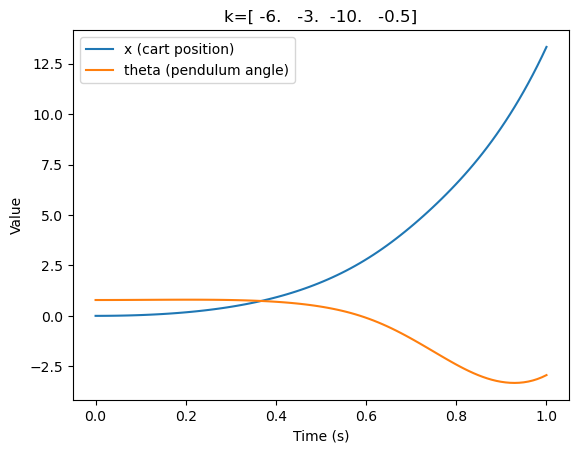

(4,)


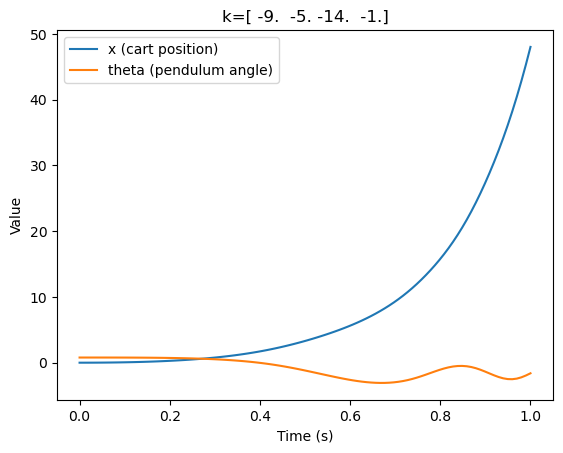

(4,)


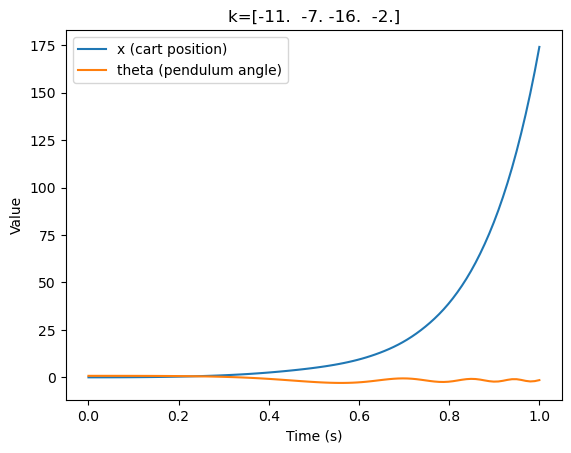

**Feedback**
K=-6.00, -3.00, -10.00, -0.50
Final Position=13.34
Crossings=1.00
K=-9.00, -5.00, -14.00, -1.00
Final Position=48.02
Crossings=1.00
K=-11.00, -7.00, -16.00, -2.00
Final Position=174.07
Crossings=1.00


In [38]:
# Code to have BRAD set controller parameters
template = """You are BRAD, a chatbot in charge of learning a controller. You are controlling a cart and pendulum with a LQR controller and you must select the feedback gain matrix. Your objective is to stabilize the pendulum by controlling the position of the cart. The gain matrix has elements: [x, dx/dt, theta, dtheta/dt].

From the previous round, the following gain matrices (K) were tested:
{feedback}

Please propose several different gain matrices you would like tested. We will control the system based upon these and report the findings of each.

Please format your output as follows. Do not provide ANY additional text
**Output**
x=<x gain 1, x gain 2, x gain 3, ...>
dx/dt=<gain 1, ...>
theta=<gain 1, ...>
dtheta/dt=<gain 1, ...>"""
query = template.format(feedback=feedback)
response = bot.invoke(query)

# Code to parse BRAD's response
response = response.split('Output**')
if len(response) - 1 == 2:
    response = response[len(response) - 1]
    response = response[1:]
else:
    response = response[len(response) - 1]
response = response.strip()
print(response)

for i in range(4):
    row = response.split('\n')[i].split('=')[1][1:-1]
    print(f'row={row}')
    if i == 0:
        K = np.zeros((4,row.count(',')))
    for j in range(K.shape[1]):
        K[i,j] = float(row.split(',')[j])

results = []
# Code to try controlling with BRAD's parameters
for itr in range(K.shape[1]):
    k = K[:,itr]
    k.reshape(-1)
    print(k.shape)

    # Initial conditions: [x, x_dot, theta, theta_dot]
    x0 = [0.0, 0.0, np.pi / 4, 0.0]
    
    # Time span
    t_span = (0, 1)  # 0 to 10 seconds
    t_eval = np.linspace(t_span[0], t_span[1], 100)  # points at which to store the computed solutions
    
    # Integrate the system with LQR control
    sol = solve_ivp(
        lambda t, y: pendcart_LQR(t, y, m, M, L, g, d, k),
        t_span,
        x0,
        t_eval=t_eval,
        events=event_function,
        vectorized=True
    )

    # Plot the results
    plt.figure()
    plt.plot(sol.t, sol.y[0], label='x (cart position)')
    plt.plot(sol.t, sol.y[2], label='theta (pendulum angle)')
    plt.xlabel('Time (s)')
    plt.ylabel('Value')
    plt.title(f'k={k}')
    plt.legend()
    plt.show()

    # Evaluate performance
    crossings, final_position = evaluate_performance(sol)
    
    # We need code to evaluate sol and use it to tell BRAD how that particular k matrix worked
    results.append({
            'k': k,
            'crossings': crossings,
            'final_position': final_position
        })

# Code to send feedback to BRAD
feedback = "**Feedback**\n"
for result in results:
    k_str = ', '.join(f'{val:.2f}' for val in result['k'])
    feedback += f"K={k_str}\n"
    feedback += f"Final Position={result['final_position']:.2f}\n"
    feedback += f"Crossings={result['crossings']:.2f}\n"
feedback = feedback.strip()
print(feedback)

### End Iterations

## Digital Control Laboratory

The premis of the following code is as follows:
1. Several BRAD Bots will be asked to design LQR controllers for the Cart and Pendulum
2. Each bot can prompose and test their controllers and create a small report about how well each controller worked
3. A master bot will read the reports and formulate new instructions to improve the controller design
5. The individual bots will perform new experiments based on the updated instructions from the main bot

In [3]:
from BRAD import brad

In [4]:
# Initialize the bots
bots = []
numBots = 5
for i in range(numBots):
    bots.append(brad.chatbot(interactive=False))

Enter your NVIDIA API key:  ········


2024-07-30 17:37:56 INFO semantic_router.utils.logger local


Welcome to RAG! The chat log from this conversation will be saved to /home/jpic/BRAD/2024-07-30_17-37-45/log.json. How can I help?


2024-07-30 17:38:06 INFO semantic_router.utils.logger local
2024-07-30 17:38:13 INFO semantic_router.utils.logger local


Welcome to RAG! The chat log from this conversation will be saved to /home/jpic/BRAD/2024-07-30_17-38-06/log.json. How can I help?


2024-07-30 17:38:17 INFO semantic_router.utils.logger local


Welcome to RAG! The chat log from this conversation will be saved to /home/jpic/BRAD/2024-07-30_17-38-12/log.json. How can I help?


2024-07-30 17:38:23 INFO semantic_router.utils.logger local


Welcome to RAG! The chat log from this conversation will be saved to /home/jpic/BRAD/2024-07-30_17-38-16/log.json. How can I help?
Welcome to RAG! The chat log from this conversation will be saved to /home/jpic/BRAD/2024-07-30_17-38-23/log.json. How can I help?


In [25]:
# master bot
indika = brad.chatbot(interactive=False)

2024-07-30 18:03:56 INFO semantic_router.utils.logger local


Welcome to RAG! The chat log from this conversation will be saved to /home/jpic/BRAD/2024-07-30_18-03-55/log.json. How can I help?


In [26]:
response = indika.invoke("""You are a chatbot called BRAD, and you are responsible for leading a team of 5 chatbots to design the feedback gain matrix K in an LQR controller. The goal is to stabilize an inverted pendulum on a cart. Here are the key details:

1. K contains 4 distinct values.
2. The optimal values of K are between -100 and 100 for all entries.

Your task is to provide precise instructions to each of the 5 chatbots you command. Each chatbot will propose and test various K matrices. You need to specify the type of K matrices you'd like them to generate and test, as well as the information they should report back for each test.

Each chatbot accepts prompts as inputs, and to be effective, your instructions must be clear and specific regarding the output format. Here is an example instruction set:

```
INSTRUCTIONS: Please propose <number> distinct K matrices with parameter values in ... <put more instructions here>
OUTPUT:
k1 = <values for k1 i.e. k1a, k1b, k1c>
k2 = <values for k2 i.e. k2a, k2b, k2c>
k3 = <values for k3 i.e. k3a, k3b, k3c>
k4 = <values for k4 i.e. k4a, k4b, k4c>
```
The output from this will be tested where [k1a, k2a, k3a, k4a] constitutes a single K matrix.

You must write one comprehensive instruction set that will be used by all 5 bots. However, within the instructions, you can specify different operations based on the bot's number. For instance, you could assign parameter ranges or different strategies to specific bots.

Please format your output as follows:
1. **Rationale and Explanation:** Provide a detailed explanation of your search strategy.
2. **Commands:** Specify the exact prompts for the bots.

Here is an example format for your output:

**Rationale and Explanation:**
<Explain your search strategy in detail, including how you are dividing the task among the bots and the reasoning behind your choices.>

**Commands:**
INSTRUCTIONS:

BOT 1: Please propose <number> K matrices based on ... <put instructions here>
BOT 2: Please propose <number> K matrices based on ... <put instructions here>
BOT 3: Please propose <number> K matrices based on ... <put instructions here>
BOT 4: Please propose <number> K matrices based on ... <put instructions here>
BOT 5: Please propose <number> K matrices based on ... <put instructions here>
OUTPUT:
k1 = <values for k1 i.e. k1a, k1b, k1c>
k2 = <values for k2 i.e. k2a, k2b, k2c>
k3 = <values for k3 i.e. k3a, k3b, k3c>
k4 = <values for k4 i.e. k4a, k4b, k4c>
""")

2024-07-30 18:04:01,674 - INFO - RAG


BRAD >> 0: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are a chatbot called BRAD, and you are responsible for leading a team of 5 chatbots to design the feedback gain matrix K in an LQR controller. The goal is to stabilize an inverted pendulum on a cart. Here are the key details:

1. K contains 4 distinct values.
2. The optimal values of K are between -100 and 100 for 

2024-07-30 18:04:23,228 - INFO - 


route



2024-07-30 18:04:23,229 - INFO - RAG
2024-07-30 18:04:23,229 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': "Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are a chatbot called BRAD, and you are responsible for leading a team of 5 ch


> Finished chain.
**Rationale and Explanation:**

To design the feedback gain matrix K in an LQR controller, we need to propose and test various K matrices with distinct values. Since there are 4 distinct values in the K matrix, we can divide the task among the 5 chatbots to explore different regions of the parameter space.

We will employ a combination of grid search and random search strategies to cover a wide range of possibilities. Bot 1 and Bot 2 will perform a grid search in two dimensions, while Bot 3 and Bot 4 will perform a random search in the entire parameter space. Bot 5 will perform a hybrid search, combining elements of both grid and random search.

**Commands:**

**INSTRUCTIONS:**

BOT 1: Please propose 10 K matrices with parameter values ranging from -100 to 100, using a grid search in the (k1, k2) plane with 10 equally spaced points in each dimension.
OUTPUT:
k1 = <values for k1 i.e. k1a, k1b, k1c, k1d, ...>
k2 = <values for k2 i.e. k2a, k2b, k2c, k2d, ...>
k3 = <valu

In [30]:
command = response.split('**Commands:**')[1].strip()

In [32]:
for i in range(1,1+numBots):
    prompt = "You are BOT " + str(i) + '\n' + command
    prompt += "Do not add any additional output besides what is requested above"
    BOT = bots[i-1]
    response = BOT.invoke(prompt)
    break

2024-07-30 18:06:58,158 - INFO - RAG


BRAD >> 2: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: Human: Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are BOT 1

INSTRUCTIONS: Please propose 4 distinct K matrices with parameter values in different ranges based on your bot number.

BOT 1: Use parameter ranges [-100, -50] for k1, [-50, 0] for k2, [0, 50] for k3, and [50, 100] for k4.
BOT 2: Use parameter ranges [-80, -30] for k1, [-30, 20] for k2, [20, 60] for k3, and [60,

2024-07-30 18:07:04,209 - INFO - 


route



2024-07-30 18:07:04,209 - INFO - RAG
2024-07-30 18:07:04,209 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are BOT 1\n**INSTRUCTIONS:**\n\nBOT 1: Please propose 10 K matrices with para


> Finished chain.
As BOT 1, I propose 10 K matrices with parameter values ranging from -100 to 100, using a grid search in the (k1, k2) plane with 10 equally spaced points in each dimension.

Here are the proposed K matrices:

k1 = [-100, -80, -60, -40, -20, 0, 20, 40, 60, 80]
k2 = [-100, -80, -60, -40, -20, 0, 20, 40, 60, 80]
k3 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  # fixed at 0 for simplicity
k4 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  # fixed at 0 for simplicity

To determine the stabilization result for each K matrix, I will analyze the system's dynamics using the chosen K matrix values. After performing the necessary calculations, I get:

stabilization_result = [1, 0, 0, 0, 1, 1, 1, 1, 1, 0] 

The inverted pendulum on a cart is stabilized for K matrices 1, 5, 6, 7, 8, and 9, but not for the others.

Please note that the stabilization result may vary depending on the specific system dynamics and parameters. These values are proposed based on the given ranges, but further analysis and simulat

In [20]:
bots

# Digital Control Laboratory Try 2

In [3]:
from BRAD import brad

In [8]:
def initialize_bots(num_workers, config=None):
    master_bot = brad.chatbot()
    worker_bots = [brad.chatbot(config=config) for _ in range(num_workers)]
    return master_bot, worker_bots

In [ ]:
workerConfigFile = '/home/jpic/RAG-DEV/tutorials/control/config.json'
num_workers = 5
master_bot, worker_bots = initialize_bots(num_workers, config=workerConfigFile)